# Lista de Exercícios - Adaline e Perceptron

## Exercício 1

Importação dos pacotes de do dataset. Teve que ser usado openML pois ele foi excluido do SKLearn por questões éticas de usar variáveis relacionadas à raça.

In [59]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import r2_score

# Baixar o dataset do OpenML
boston = fetch_openml(name="boston", version=1, as_frame=True)

# Dados e alvo
X = boston.data
y = boston.target



Verificação de nulos e dos dtypes

In [60]:
X.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [34]:
X.dtypes

CRIM        float64
ZN          float64
INDUS       float64
CHAS       category
NOX         float64
RM          float64
AGE         float64
DIS         float64
RAD        category
TAX         float64
PTRATIO     float64
B           float64
LSTAT       float64
dtype: object

In [35]:
X.nunique()

CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
dtype: int64

In [37]:
X.RAD.unique()

['1', '2', '3', '5', '4', '8', '6', '7', '24']
Categories (9, object): ['1', '2', '24', '3', ..., '5', '6', '7', '8']

Sa colunas CHAS e RAD são as unicas duas categóricas. Quando analisamos os atributos temos o seguinte:

- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per $10,000
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT - % lower status of the population
- MEDV - Median value of owner-occupied homes in $1000's

CHAS é uma variável binária, então pode ser transformada em numérica. RAD é uma variável numérica de indice de acessibilidade. Ela representa um indice em que mais alto, maior a acessibilidade. Por isso acho que também faz sentido transformar ela em numérica diretamente.

In [48]:
X = X.astype(np.float64).values

Divisão de treino-teste, treinamento usando pseudoinversa e inferência

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_bias = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test_bias = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

w = np.linalg.pinv(X_train_bias) @ y_train
y_pred = X_test_bias @ w

Resultados

In [58]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE no conjunto de teste: {mse:.2f}")
print(f"RMSE no conjunto de teste: {rmse:.2f}")
print(f"R² no conjunto de teste: {r2:.4f}")

MSE no conjunto de teste: 24.29
RMSE no conjunto de teste: 4.93
R² no conjunto de teste: 0.6688


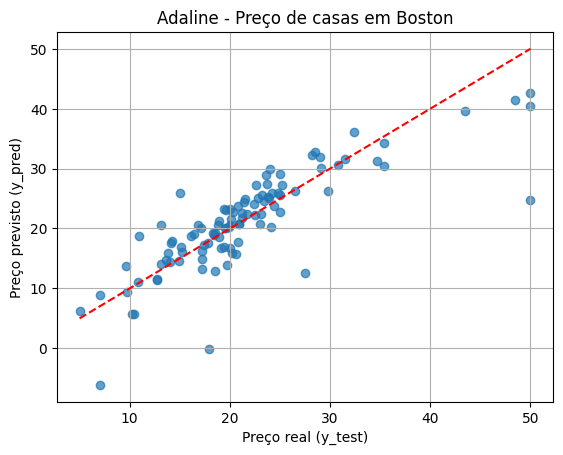

In [55]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Preço real (y_test)")
plt.ylabel("Preço previsto (y_pred)")
plt.title("Adaline - Preço de casas em Boston")
plt.grid(True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # linha ideal
plt.show()


## Exercício 2

Load do dataset

In [61]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm

data = load_breast_cancer()
X = data.data
y = data.target

In [63]:

X = np.hstack([X, np.ones((X.shape[0], 1))])

kf = KFold(n_splits=10, shuffle=True, random_state=42)


In [94]:
taxa_aprendizado = 0.01
epocas = 500

# Arrays para armazenar métricas por época
medias_por_epoca = np.zeros(epocas)
desvios_por_epoca = np.zeros(epocas)

acuracias = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # criação dos pesos
    w = np.zeros(X_train.shape[1])
    acuracias_fold = []
    
    # loop de treinamento
    for epoca in range(epocas):
        for i in range(X_train.shape[0]):
            xi = X_train[i]
            yi = y_train[i]

            y_pred = 1 if np.dot(w, xi) >= 0 else 0
            # backpropagation
            if y_pred != yi:
                w = w + taxa_aprendizado * (yi - y_pred) * xi
        
        # avaliar no fim da época
        y_pred_test = np.where(np.dot(X_test, w) >= 0, 1, 0)
        acuracia = accuracy_score(y_test, y_pred_test) * 100
        acuracias_fold.append(acuracia)
    
    acuracias.append(acuracias_fold)


In [98]:
acuracias_array = np.array(acuracias)

# Calcular médias e desvios padrão para cada época
medias_por_epoca = np.mean(acuracias_array, axis=0)
desvios_por_epoca = np.std(acuracias_array, axis=0)

# Criar DataFrame com resultados
df_resultados = pd.DataFrame([{
    'Época': e + 1,
    **{f'Fold {i+1}': acuracias_array[i][e] for i in range(len(acuracias))},
    'Média': medias_por_epoca[e],
    'Desvio Padrão': desvios_por_epoca[e]
} for e in range(epocas)])

# Configurar formato de exibição dos números
pd.set_option('display.float_format', '{:.2f}'.format)

# Exibir o DataFrame
display(df_resultados.iloc[-20:])

,Época,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Média,Desvio Padrão
480,481,82.46,91.23,92.98,70.18,80.70,87.72,84.21,82.46,91.23,91.07,85.42,6.60
481,482,92.98,85.96,92.98,92.98,80.70,87.72,84.21,84.21,91.23,73.21,86.62,6.09
482,483,82.46,87.72,94.74,91.23,82.46,85.96,94.74,84.21,84.21,91.07,87.88,4.53
483,484,92.98,85.96,92.98,91.23,66.67,89.47,92.98,85.96,91.23,91.07,88.05,7.55
484,485,94.74,87.72,92.98,91.23,82.46,87.72,84.21,85.96,84.21,91.07,88.23,3.92
485,486,98.25,91.23,94.74,92.98,66.67,87.72,84.21,82.46,91.23,73.21,86.27,9.41
486,487,82.46,91.23,92.98,89.47,82.46,87.72,84.21,87.72,84.21,91.07,87.35,3.65
487,488,82.46,85.96,94.74,89.47,66.67,87.72,84.21,84.21,91.23,73.21,83.99,7.97
488,489,92.98,89.47,94.74,70.18,82.46,87.72,84.21,85.96,91.23,91.07,87.00,6.70
489,490,94.74,91.23,94.74,70.18,84.21,87.72,92.98,85.96,84.21,73.21,85.92,8.07


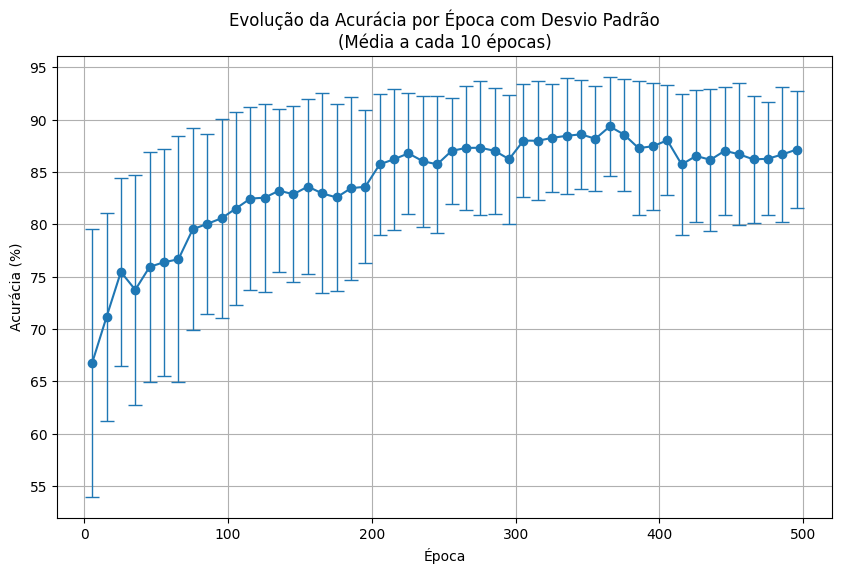

In [96]:
# Criar coluna de grupo (cada grupo representa 10 épocas)
df_resultados['Grupo'] = (df_resultados['Época'] - 1) // 10

# Calcular médias e desvios por grupo
df_agrupado = df_resultados.groupby('Grupo').agg({
    'Época': 'mean',
    'Média': 'mean',
    'Desvio Padrão': 'mean'
}).reset_index()

# Plotar o gráfico com barras de erro usando dados agrupados
plt.figure(figsize=(10, 6))
plt.errorbar(df_agrupado['Época'], 
             df_agrupado['Média'], 
             yerr=df_agrupado['Desvio Padrão'],
             fmt='o-', capsize=5, capthick=1, elinewidth=1)

plt.xlabel('Época')
plt.ylabel('Acurácia (%)')
plt.title('Evolução da Acurácia por Época com Desvio Padrão\n(Média a cada 10 épocas)')
plt.grid(True)
plt.show()

In [100]:
df_resultados['Média'].max()

np.float64(91.73872180451127)

In [102]:
df_resultados['Média'].iloc[-1]

np.float64(86.47556390977444)

É possivel perceber que a partir de 300 épocas a acurácia é estabilizada. A acurácia média nas ultimas épocas gira em torno de 87%. Comparado com o outro exercício do mesmo problema que foi resolvido usando RBF com K means:
RBF-Kmeans: 95.57%
Perceptron: 86.47% (ultima acurácia), 91.73% (máxima acurácia)

Visto que o RBF é básicamente um perceptron com uma camada escondida que fornece mais informação sobre o problema informando a média de distância de cada ponto com cada centro de clsuter no Kmeans, faz sentido que o RBF tenha um resultado melhor.